# Abstracts LDA

* Load the abstracts from the research articles identified in 10_research_papers notebook.
* Create a corpus with the abstracts
* Tokenize
* Apply single LDA
* Apply ensemble LDA

In [2]:
import pandas as pd
import os
import PyPDF2
from collections import defaultdict
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import EnsembleLda
from gensim.parsing.preprocessing import preprocess_string

import numpy as np
from random import sample 

In [3]:
from matplotlib import pyplot as plt 

%matplotlib inline

## Load the abstracts 
* From the research articles on machine learning identified in 10_research_papers  notebook. Keep only the abstracts.
* Random sample 1000 papers

In [4]:
%%time

arxiv_ml_research = pd.read_csv('data/arxiv_ml_research.csv.zip')

CPU times: user 1.89 s, sys: 287 ms, total: 2.17 s
Wall time: 2.35 s


<timed exec>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


In [5]:
print(f"There are {arxiv_ml_research.shape[0]} research articles on machine learning in the dataset")

There are 207226 research articles on machine learning in the dataset


## Create a corpus with the abstracts

In [59]:
documents = arxiv_ml_research['abstract']

In [60]:
len(documents)

207226

### Random sample papers

In [61]:
sample_size = 50000
documents = sample(list(documents), sample_size)

### Tokenize

In [62]:
# remove common words and tokenize
texts = [
    preprocess_string(document)
    for document in documents
]

In [63]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [64]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

In [65]:
len(dictionary)

5116

## Apply single LDA
Simple 1-topic LDA

In [66]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=1)
corpus_lda = lda_model[corpus]

In [67]:
lda_model.print_topics()

[(0,
  '0.011*"data" + 0.010*"method" + 0.008*"network" + 0.008*"base" + 0.008*"train" + 0.008*"gener" + 0.007*"perform" + 0.007*"algorithm" + 0.006*"approach" + 0.006*"task"')]

## Apply ensemble LDA

In [68]:
topic_model_class = LdaModel
ensemble_workers = 12
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 100
passes = 2

In [69]:
ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=topic_model_class,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

* Compute all the topics. In this setup: num_topics * num_workers
* Compute the stable topics

In [70]:
print(len(ensemble.ttda))
print(len(ensemble.get_topics()))

2400
7


In [71]:
ensemble.print_topics()

[(0,
  '0.165*"graph" + 0.038*"node" + 0.032*"structur" + 0.020*"network" + 0.017*"gnn" + 0.016*"method" + 0.014*"inform" + 0.013*"represent" + 0.011*"base" + 0.010*"edg"'),
 (1,
  '0.098*"adversari" + 0.098*"attack" + 0.040*"robust" + 0.022*"exampl" + 0.020*"defens" + 0.019*"train" + 0.018*"perturb" + 0.014*"vulner" + 0.012*"method" + 0.010*"box"'),
 (2,
  '0.118*"network" + 0.068*"neural" + 0.031*"deep" + 0.023*"train" + 0.020*"layer" + 0.018*"architectur" + 0.011*"convolut" + 0.009*"method" + 0.008*"perform" + 0.008*"base"'),
 (3,
  '0.121*"domain" + 0.051*"target" + 0.033*"sourc" + 0.031*"adapt" + 0.030*"transfer" + 0.017*"data" + 0.012*"method" + 0.011*"perform" + 0.010*"dataset" + 0.010*"train"'),
 (4,
  '0.123*"user" + 0.060*"recommend" + 0.034*"item" + 0.021*"interact" + 0.016*"system" + 0.016*"base" + 0.016*"prefer" + 0.010*"inform" + 0.010*"person" + 0.008*"experi"'),
 (5,
  '0.173*"cluster" + 0.028*"data" + 0.026*"method" + 0.020*"mean" + 0.014*"algorithm" + 0.013*"dataset" 

## Tuning

In [72]:
shape = ensemble.asymmetric_distance_matrix.shape
shape

(2400, 2400)

In [73]:
without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
print(without_diagonal.min(), without_diagonal.mean(), without_diagonal.max())

0.008115892128274793 0.7719404687463888 1.0


In [97]:
num_topics = []
perplexity = []
eps = []
range = np.linspace(without_diagonal.min(), without_diagonal.max(), num=25)
for val in range:
    ensemble.recluster(eps=val)
    topics = len(ensemble.get_topics())
    num_topics.append(topics)
    eps.append(val)
    if topics > 1:
        perplexity_eps = ensemble.log_perplexity(corpus)
        perplexity.append(perplexity_eps)
        print(f"eps: {val} stable number of topics: {topics}, perplexity: {perplexity_eps}")
    else:
        perplexity.append(-np.inf)


eps: 0.09077290111758522 stable number of topics: 7, perplexity: -7.746052689569602
eps: 0.13210140561224043 stable number of topics: 9, perplexity: -7.582771821123915
eps: 0.17342991010689565 stable number of topics: 16, perplexity: -7.389443696045238
eps: 0.21475841460155087 stable number of topics: 20, perplexity: -7.3284140871205725
eps: 0.25608691909620607 stable number of topics: 25, perplexity: -7.319488982819744
eps: 0.2974154235908613 stable number of topics: 32, perplexity: -7.341724565338382
eps: 0.3387439280855165 stable number of topics: 36, perplexity: -7.359743666523391
eps: 0.3800724325801717 stable number of topics: 29, perplexity: -7.3280724106914
eps: 0.42140093707482695 stable number of topics: 22, perplexity: -7.363392069260584
eps: 0.46272944156948215 stable number of topics: 13, perplexity: -7.413312854878545
eps: 0.5040579460641373 stable number of topics: 9, perplexity: -7.460150922715606
eps: 0.5453864505587925 stable number of topics: 7, perplexity: -7.643901

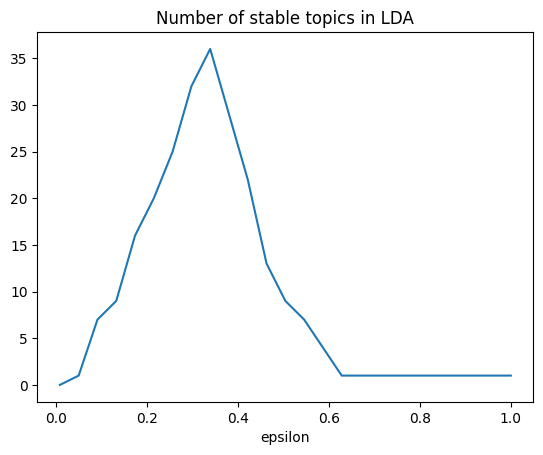

In [98]:
plt.plot(eps, num_topics)
plt.title("Number of stable topics in LDA")
plt.xlabel("epsilon")
plt.show()

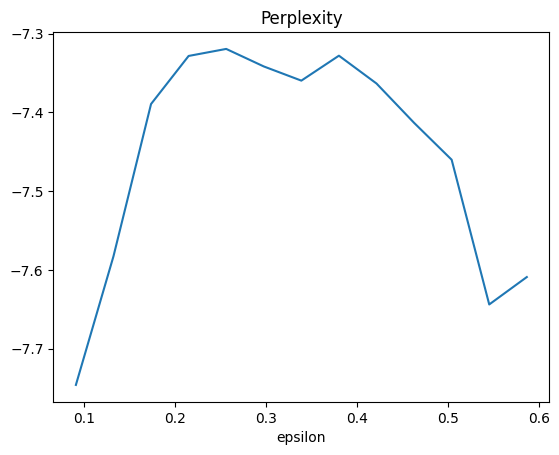

In [99]:
plt.plot(eps, perplexity)
plt.title("Perplexity")
plt.xlabel("epsilon")
plt.show()

In [100]:
eps[perplexity.index(max(perplexity))]

0.25608691909620607

In [101]:
eps = 0.25608691909620607
ensemble.recluster(eps=eps, min_samples=2, min_cores=2)
ensemble.print_topics()

[(24,
  '0.069*"robot" + 0.019*"environ" + 0.017*"plan" + 0.015*"navig" + 0.014*"task" + 0.011*"object" + 0.011*"human" + 0.009*"approach" + 0.008*"base" + 0.008*"algorithm"'),
 (18,
  '0.115*"knowledg" + 0.013*"distil" + 0.011*"teacher" + 0.011*"student" + 0.011*"task" + 0.011*"dataset" + 0.010*"base" + 0.009*"perform" + 0.009*"gener" + 0.008*"reason"'),
 (52,
  '0.097*"attent" + 0.042*"mechan" + 0.032*"transform" + 0.014*"self" + 0.009*"base" + 0.009*"perform" + 0.008*"sequenc" + 0.007*"method" + 0.007*"task" + 0.007*"state"'),
 (35,
  '0.124*"ensembl" + 0.026*"arm" + 0.022*"varianc" + 0.019*"sub" + 0.017*"mobil" + 0.016*"dropout" + 0.016*"gap" + 0.013*"detector" + 0.009*"tag" + 0.009*"method"'),
 (53,
  '0.073*"rank" + 0.037*"matrix" + 0.020*"low" + 0.016*"method" + 0.014*"tensor" + 0.013*"algorithm" + 0.012*"problem" + 0.012*"decomposit" + 0.010*"factor" + 0.010*"matric"'),
 (42,
  '0.130*"dnn" + 0.015*"server" + 0.015*"backdoor" + 0.015*"spars" + 0.013*"deep" + 0.011*"precis" + 0.